In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epydemics import DataContainer, Model

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Epydemics v0.9.0 - Incidence Mode Demo")

Epydemics v0.9.0 - Incidence Mode Demo


## 1. Load Measles Incident Data

Measles data from countries with elimination programs typically reports **incident cases per year**, not cumulative totals. This makes `mode='incidence'` the natural choice.

We'll simulate Mexico measles data (2010-2024):
- 2010-2014: Sporadic imported cases
- 2015-2019: Near elimination (few cases)
- 2020-2024: Reintroduction and outbreaks

In [2]:
# Realistic Mexico measles pattern (15 years)
np.random.seed(42)
dates = pd.date_range('2010', periods=15, freq='YE')

# Incident cases per year (realistic pattern)
incident_cases = np.array([
    220, 55, 667, 164, 81,   # 2010-2014: sporadic
    34, 12, 0, 0, 4,         # 2015-2019: near elimination
    18, 45, 103, 67, 89      # 2020-2024: reintroduction
])

# Deaths (CFR ~0.1-0.2% for measles)
incident_deaths = np.array([1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1])
cumulative_deaths = np.cumsum(incident_deaths)

# Population (Mexico ~130M)
population = [120_000_000 + i*2_000_000 for i in range(15)]

# Create DataFrame with INCIDENT cases (I) and cumulative deaths (D)
measles_data = pd.DataFrame({
    'I': incident_cases,        # NEW: Incident cases (can vary)
    'D': cumulative_deaths,     # Cumulative deaths (monotonic)
    'N': population
}, index=dates)

print("Mexico Measles Data (2010-2024)")
print("="*60)
print(measles_data)
print(f"\nData shape: {measles_data.shape}")
print(f"Total cases (sum of I): {incident_cases.sum()}")

Mexico Measles Data (2010-2024)
              I  D          N
2010-12-31  220  1  120000000
2011-12-31   55  1  122000000
2012-12-31  667  3  124000000
2013-12-31  164  4  126000000
2014-12-31   81  4  128000000
2015-12-31   34  4  130000000
2016-12-31   12  4  132000000
2017-12-31    0  4  134000000
2018-12-31    0  4  136000000
2019-12-31    4  4  138000000
2020-12-31   18  4  140000000
2021-12-31   45  5  142000000
2022-12-31  103  7  144000000
2023-12-31   67  8  146000000
2024-12-31   89  9  148000000

Data shape: (15, 3)
Total cases (sum of I): 1559


## 2. Visualize Incident Pattern

Notice how incident cases **can decrease** (unlike cumulative data which must be monotonic).

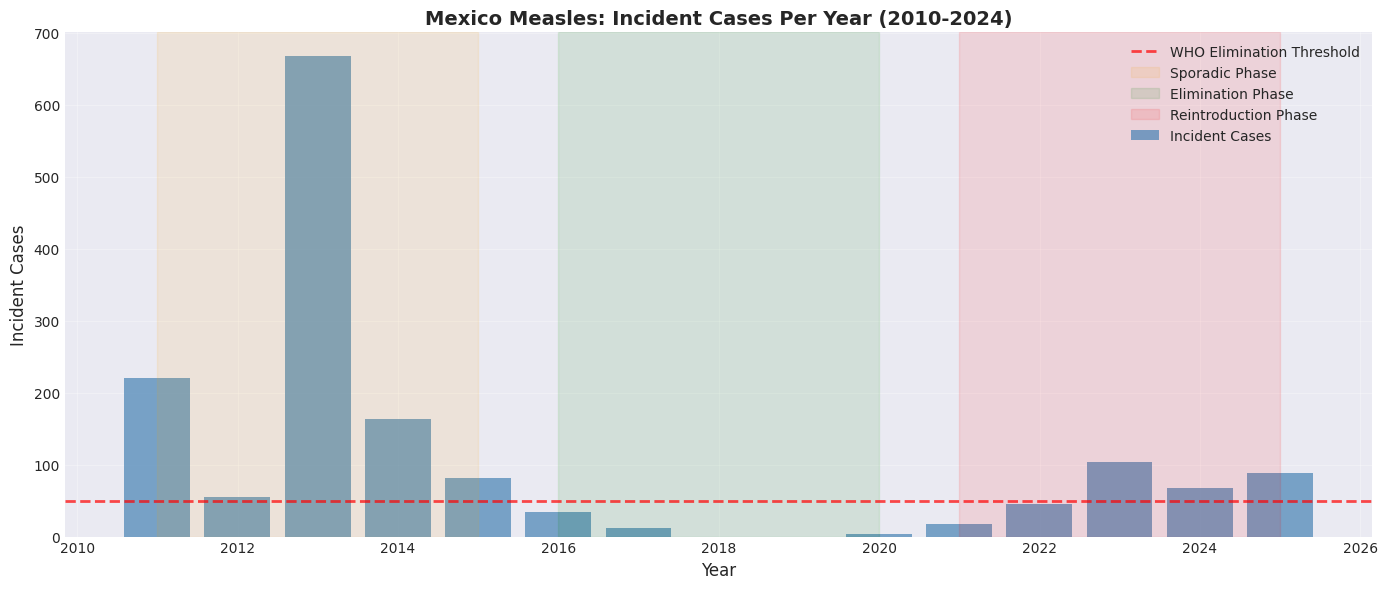


Incident Cases Statistics:
Mean: 103.9
Std Dev: 162.2
Min: 0
Max: 667

Elimination achieved in: 2 years


In [3]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot incident cases
ax.bar(dates, incident_cases, width=300, alpha=0.7, color='steelblue', label='Incident Cases')
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='WHO Elimination Threshold')

# Annotate periods
ax.axvspan(dates[0], dates[4], alpha=0.1, color='orange', label='Sporadic Phase')
ax.axvspan(dates[5], dates[9], alpha=0.1, color='green', label='Elimination Phase')
ax.axvspan(dates[10], dates[14], alpha=0.1, color='red', label='Reintroduction Phase')

ax.set_title('Mexico Measles: Incident Cases Per Year (2010-2024)', fontsize=14, fontweight='bold')
ax.set_ylabel('Incident Cases', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show variation
print(f"\nIncident Cases Statistics:")
print(f"Mean: {incident_cases.mean():.1f}")
print(f"Std Dev: {incident_cases.std():.1f}")
print(f"Min: {incident_cases.min()}")
print(f"Max: {incident_cases.max()}")
print(f"\nElimination achieved in: {(incident_cases == 0).sum()} years")

## 3. Create DataContainer in Incidence Mode

**Key Innovation**: Set `mode='incidence'` to tell epydemics that `I` contains **incident** (not derived) cases.

The system will:
- Preserve `I` values (don't recalculate from C)
- Generate `C` by cumulative sum: `C = cumsum(I)`
- Calculate all other compartments (S, R, A) normally

In [4]:
# Create DataContainer in INCIDENCE mode
container = DataContainer(measles_data, mode='incidence', window=3)

print("DataContainer Summary")
print("="*60)
print(f"Mode: {container.mode}")
print(f"Original columns: {list(measles_data.columns)}")
print(f"Processed columns: {list(container.data.columns)}")
print(f"\nFirst 5 rows of processed data:")
print(container.data.head())

# Verify C is monotonic even though I varies
print(f"\nVerifying C monotonicity:")
C_diffs = container.data['C'].diff().dropna()
print(f"All C differences >= 0: {all(C_diffs >= -1e-10)}")
print(f"I can vary up/down: {any(container.data['I'].diff().dropna() < 0)}")

2025-12-23 21:17:49,867 - root - INFO - Auto-detected frequency: YE
2025-12-23 21:17:49,867 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-23 21:17:49,868 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-23 21:17:49,872 - root - INFO - No vaccination data detected. Using SIRD model.


DataContainer Summary
Mode: incidence
Original columns: ['I', 'D', 'N']
Processed columns: ['I', 'D', 'N', 'C', 'R', 'S', 'A', 'dC', 'dA', 'dS', 'dI', 'dR', 'dD', 'alpha', 'beta', 'gamma', 'R0', 'logit_alpha', 'logit_beta', 'logit_gamma']

First 5 rows of processed data:
              I  D          N     C            R          S          A   dC  \
2010-12-31  220  1  120000000   220   210.561644  119999780  120000000  220   
2011-12-31   55  1  122000000   275   271.890411  121999725  121999780   55   
2012-12-31  667  3  124000000   942   913.416438  123999058  123999725  667   
2013-12-31  164  4  126000000  1106  1095.709589  125998894  125999058  164   
2014-12-31   81  4  128000000  1187  1179.893151  127998813  127998894   81   

                   dA         dS     dI          dR   dD  alpha      beta  \
2010-12-31  1999780.0  1999945.0 -165.0   61.328767 -0.0    1.0  0.278767   
2011-12-31  1999945.0  1999333.0  612.0  641.526027  2.0    1.0  1.000000   
2012-12-31  1999333.0 

## 4. Inspect Compartments

In incidence mode:
- **I** = incident cases (preserved from input)
- **C** = cumulative cases (generated via cumsum)
- **S** = susceptible (N - I - R - D)
- **R** = recovered (C - D - I, with 14-day lag)
- **A** = active population (S + I)

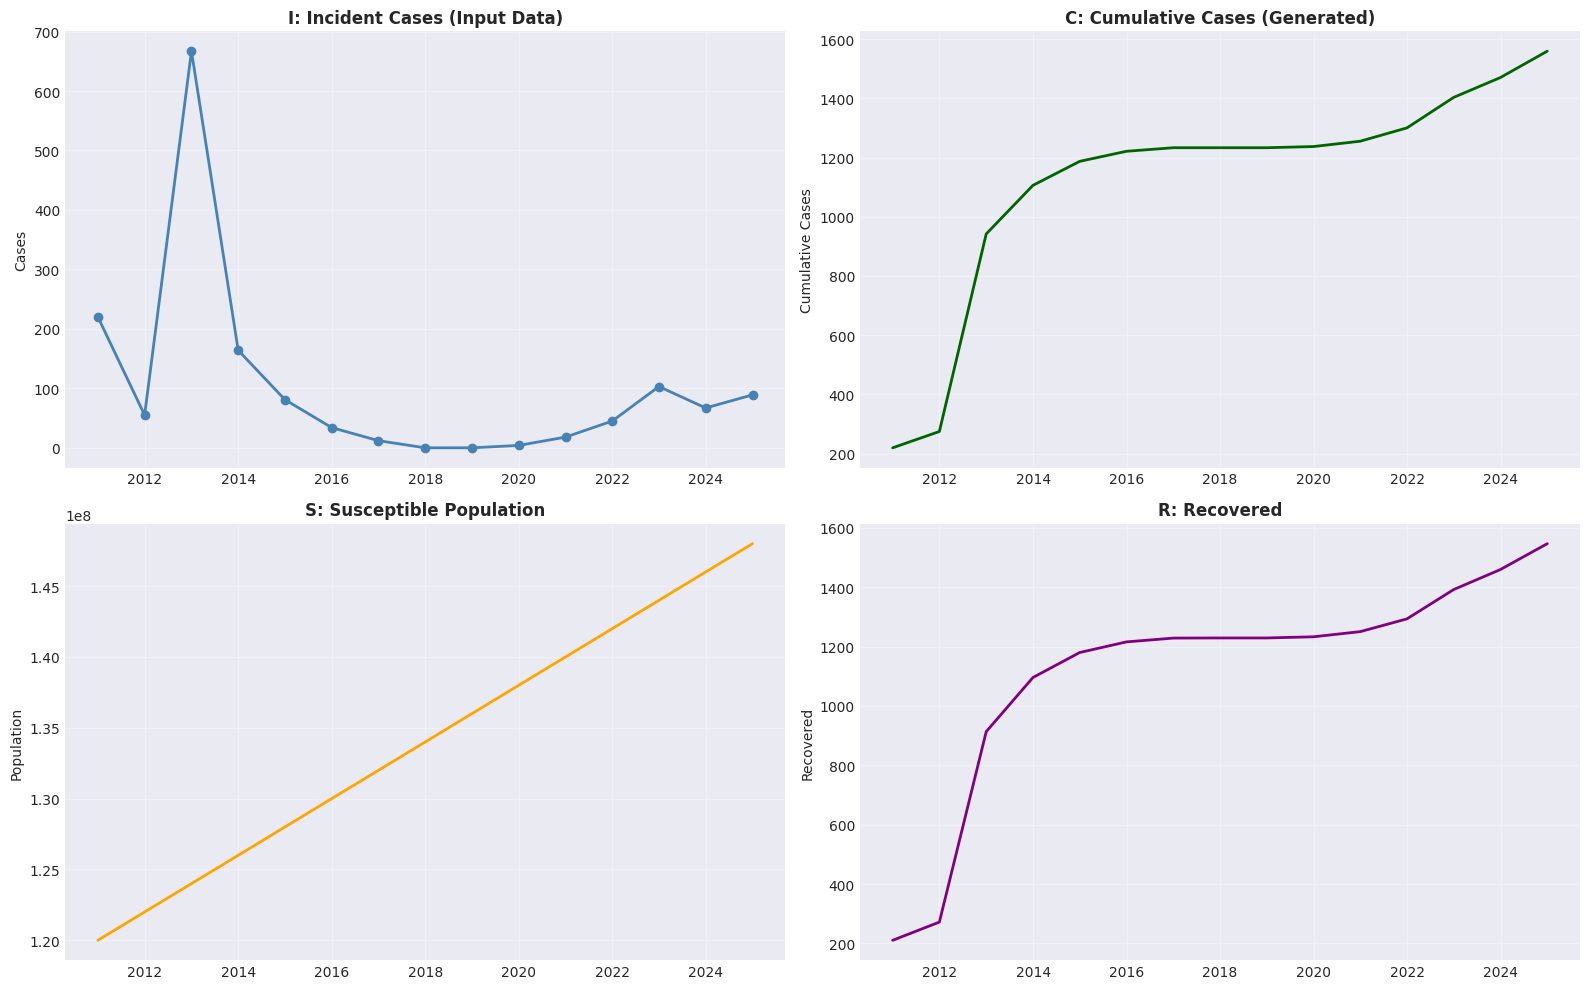

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# I: Incident cases (can vary)
ax1 = axes[0, 0]
ax1.plot(container.data.index, container.data['I'], marker='o', linewidth=2, color='steelblue')
ax1.set_title('I: Incident Cases (Input Data)', fontweight='bold')
ax1.set_ylabel('Cases')
ax1.grid(True, alpha=0.3)

# C: Cumulative cases (monotonic)
ax2 = axes[0, 1]
ax2.plot(container.data.index, container.data['C'], linewidth=2, color='darkgreen')
ax2.set_title('C: Cumulative Cases (Generated)', fontweight='bold')
ax2.set_ylabel('Cumulative Cases')
ax2.grid(True, alpha=0.3)

# S: Susceptible population
ax3 = axes[1, 0]
ax3.plot(container.data.index, container.data['S'], linewidth=2, color='orange')
ax3.set_title('S: Susceptible Population', fontweight='bold')
ax3.set_ylabel('Population')
ax3.grid(True, alpha=0.3)

# R: Recovered
ax4 = axes[1, 1]
ax4.plot(container.data.index, container.data['R'], linewidth=2, color='purple')
ax4.set_title('R: Recovered', fontweight='bold')
ax4.set_ylabel('Recovered')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Create and Fit Model

The `Model` class automatically inherits the mode from the `DataContainer`.

In [6]:
# Create Model (inherits mode='incidence')
model = Model(container)

print("Model Configuration")
print("="*60)
print(f"Mode: {model.mode}")
print(f"Data shape: {model.data.shape}")
print(f"Columns: {list(model.data.columns)}")

# Verify mode propagated
assert model.mode == 'incidence', "Mode should propagate from DataContainer!"
print("\nMode successfully propagated from DataContainer to Model")

2025-12-23 21:17:50,816 - root - INFO - Model initialized with 3 rates (SIRD mode), forecaster='var'
2025-12-23 21:17:50,820 - root - INFO - Forecasting orchestrator initialized: backend='var', 3 rates (SIRD (3-rate))


Model Configuration
Mode: incidence
Data shape: (15, 20)
Columns: ['I', 'D', 'N', 'C', 'R', 'S', 'A', 'dC', 'dA', 'dS', 'dI', 'dR', 'dD', 'alpha', 'beta', 'gamma', 'R0', 'logit_alpha', 'logit_beta', 'logit_gamma']

Mode successfully propagated from DataContainer to Model


In [7]:
# Fit VAR model (VAR automatically handles incidence mode rates)
model.create_model()
model.fit_model(max_lag=3)

print("Model Fitted")
print("="*60)
print(f"VAR model order: {model.var_forecasting.logit_ratios_model_fitted.k_ar}")
print(f"Rates modeled: {model.var_forecasting.active_logit_ratios}")
print(f"\nIncidence mode note: alpha, beta, gamma calculated from incident I (not derived I)")

2025-12-23 21:17:50,848 - root - WARNING - Detected constant columns: [0]. VAR fitting will use trend='n' to avoid conflicts.
2025-12-23 21:17:50,852 - root - WARNING - Reduced max_lag from 3 to 1 due to limited observations (15)
2025-12-23 21:17:50,853 - root - INFO - Using trend='n' (no trend) due to constant columns


Model Fitted
VAR model order: 1
Rates modeled: ['logit_alpha', 'logit_beta', 'logit_gamma']

Incidence mode note: alpha, beta, gamma calculated from incident I (not derived I)


## 6. Forecast Future Outbreaks

Forecast 5 years ahead (2025-2029). The model will predict incident case patterns based on historical sporadic/outbreak cycles.

In [8]:
# Forecast 5 years ahead
forecast_steps = 5
model.forecast(steps=forecast_steps)

print("Forecasting Complete")
print("="*60)
print(f"Forecast horizon: {forecast_steps} years")
print(f"Forecast dates: {model.forecasting_interval[0]} to {model.forecasting_interval[-1]}")
print(f"\nForecasted rates (alpha, beta, gamma) available with confidence intervals")

2025-12-23 21:17:51,049 - root - INFO - Simulation initialized without vaccination (SIRD mode)


Forecasting Complete
Forecast horizon: 5 years
Forecast dates: 2025-01-01 00:00:00 to 2025-01-05 00:00:00

Forecasted rates (alpha, beta, gamma) available with confidence intervals


## 7. Run Monte Carlo Simulations

Generate 27 epidemic scenarios (3×3×3 confidence levels for alpha, beta, gamma).

In [9]:
# Run simulations (sequential for reproducibility)
model.run_simulations(n_jobs=1)
model.generate_result()

print("Simulation Complete")
print("="*60)
print(f"Scenarios: 27 (3×3×3 for SIRD)")
print(f"Compartments: {list(model.results.keys())}")
print(f"\nResults shape (C): {model.results['C'].shape}")
print(f"Central tendencies: mean, median, gmean, hmean")

2025-12-23 21:17:51,063 - root - INFO - Running 27 SIRD scenarios (3^3)


Simulation Complete
Scenarios: 27 (3×3×3 for SIRD)
Compartments: ['A', 'C', 'S', 'I', 'R', 'D']

Results shape (C): (5, 31)
Central tendencies: mean, median, gmean, hmean


## 8. Visualize Forecast Results

Compare forecasted incident cases (I) against historical patterns.

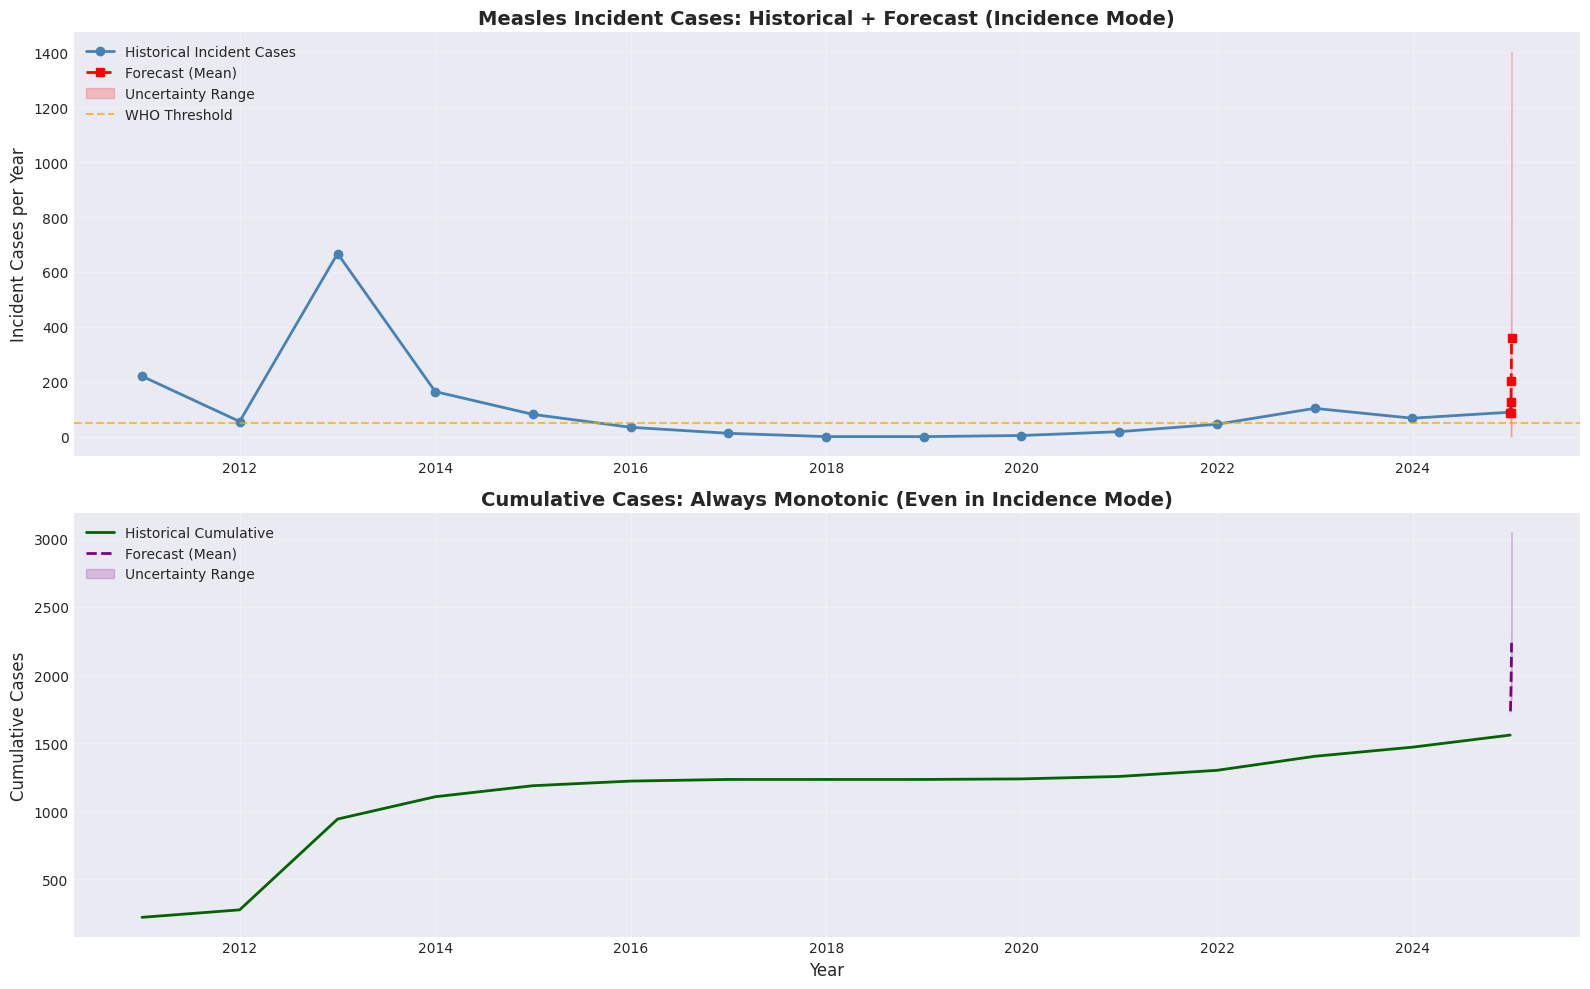

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Incident cases (I) - can vary up/down
ax1 = axes[0]

# Historical I
hist_I = model.data['I']
ax1.plot(hist_I.index, hist_I.values, marker='o', linewidth=2, 
         markersize=6, color='steelblue', label='Historical Incident Cases')

# Forecasted I (mean)
forecast_I = model.results['I']['mean']
ax1.plot(forecast_I.index, forecast_I.values, marker='s', linewidth=2, 
         markersize=6, color='red', linestyle='--', label='Forecast (Mean)')

# Confidence envelope (using all scenarios)
I_lower = model.results['I'].filter(like='lower').min(axis=1)
I_upper = model.results['I'].filter(like='upper').max(axis=1)
ax1.fill_between(forecast_I.index, I_lower, I_upper, alpha=0.2, color='red', label='Uncertainty Range')

ax1.axhline(y=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='WHO Threshold')
ax1.set_title('Measles Incident Cases: Historical + Forecast (Incidence Mode)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Incident Cases per Year', fontsize=12)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative cases (C) - always monotonic
ax2 = axes[1]

# Historical C
hist_C = model.data['C']
ax2.plot(hist_C.index, hist_C.values, linewidth=2, color='darkgreen', label='Historical Cumulative')

# Forecasted C (mean)
forecast_C = model.results['C']['mean']
ax2.plot(forecast_C.index, forecast_C.values, linewidth=2, 
         color='purple', linestyle='--', label='Forecast (Mean)')

# Confidence envelope
C_lower = model.results['C'].filter(like='lower').min(axis=1)
C_upper = model.results['C'].filter(like='upper').max(axis=1)
ax2.fill_between(forecast_C.index, C_lower, C_upper, alpha=0.2, color='purple', label='Uncertainty Range')

ax2.set_title('Cumulative Cases: Always Monotonic (Even in Incidence Mode)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Cases', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Compare: Incidence vs Cumulative Mode

**Key Difference**: 
- **Incidence Mode**: I values come directly from data (can vary)
- **Cumulative Mode**: I derived from C differences (always increasing in epidemic phase)

Let's process the same data both ways to see the difference.

2025-12-23 21:17:51,923 - root - INFO - Auto-detected frequency: YE
2025-12-23 21:17:51,924 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-23 21:17:51,927 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-23 21:17:51,929 - root - INFO - No vaccination data detected. Using SIRD model.


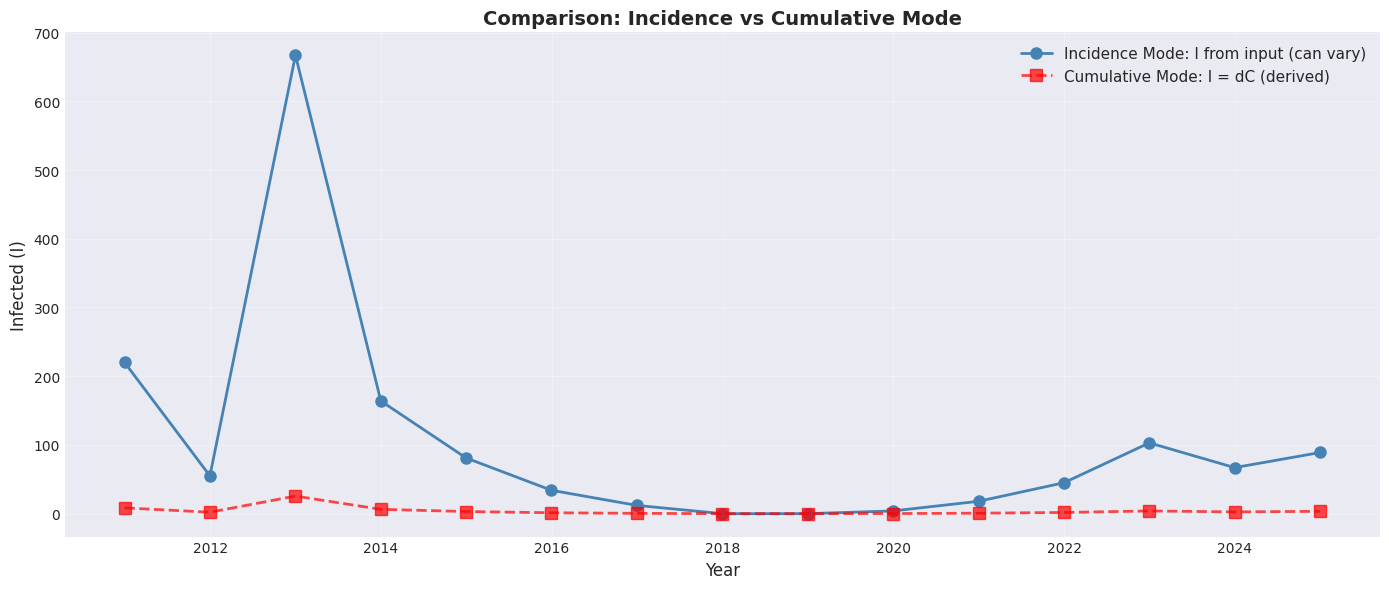

Incidence vs Cumulative Mode Comparison
Incidence I: Can vary up/down = True
Cumulative I: Always derived from C = True

Max difference: 641.42


In [11]:
# Create cumulative version of the data
measles_cumulative = pd.DataFrame({
    'C': np.cumsum(incident_cases),  # Cumulative cases
    'D': cumulative_deaths,
    'N': population
}, index=dates)

# Process in cumulative mode
container_cumulative = DataContainer(measles_cumulative, mode='cumulative', window=3)

# Compare I values
fig, ax = plt.subplots(figsize=(14, 6))

# Incidence mode: I from input
I_incidence = container.data['I'].dropna()
ax.plot(I_incidence.index, I_incidence.values, marker='o', linewidth=2, 
        markersize=8, color='steelblue', label='Incidence Mode: I from input (can vary)')

# Cumulative mode: I = dC (derived)
I_cumulative = container_cumulative.data['I'].dropna()
ax.plot(I_cumulative.index, I_cumulative.values, marker='s', linewidth=2, 
        markersize=8, color='red', alpha=0.7, linestyle='--', label='Cumulative Mode: I = dC (derived)')

ax.set_title('Comparison: Incidence vs Cumulative Mode', fontsize=14, fontweight='bold')
ax.set_ylabel('Infected (I)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print difference
print("Incidence vs Cumulative Mode Comparison")
print("="*60)
print(f"Incidence I: Can vary up/down = {any(I_incidence.diff().dropna() < 0)}")
print(f"Cumulative I: Always derived from C = {any(I_cumulative.diff().dropna() < 0)}")
print(f"\nMax difference: {abs(I_incidence - I_cumulative).max():.2f}")

## Summary: When to Use Incidence Mode

✅ **Use `mode='incidence'` when:**
- Data reports **incident cases per time period** (not cumulative)
- Cases can **decrease** between time points (elimination → outbreak cycles)
- Disease: Measles, polio, other vaccine-preventable diseases with near-elimination
- Frequency: Annual, quarterly, or other coarse time scales

✅ **Use `mode='cumulative'` when:**
- Data reports **total cumulative cases**
- Cases always **increase monotonically**
- Disease: COVID-19, flu pandemics, endemic diseases
- Frequency: Daily updates with running totals

**Technical Note**: In both modes, the underlying SIRD equations and VAR forecasting work identically. The difference is only in **data interpretation**:
- Incidence: `I` is input → generate `C = cumsum(I)`
- Cumulative: `C` is input → generate `I = diff(C)`

**Next Steps**: Try this with real OWID data for Mexico, USA, or other countries with measles reporting!